## **Kütüphanelerin Eklenmesi**

Projede kullanılacak kütüphanelerin içe aktarılması.

In [1]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

## **Verilerin Okunması**


Verilerin okunup dataframe' e kaydedilmesi.

In [2]:
label = []
path = []
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            if dir_name.split()[-1] != 'GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))

data = pd.DataFrame(columns=['path','label'])
data['path'] = path
data['label'] = label

In [3]:
data

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
...,...,...
8995,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8996,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8997,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8998,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream


## **EDA**

Her sınıftan bir örnek görüntü göstermek için yazdığım kod. Kategoriler arasından eşsiz olan her kategori için örnek bir fotoğraf getiriyor.

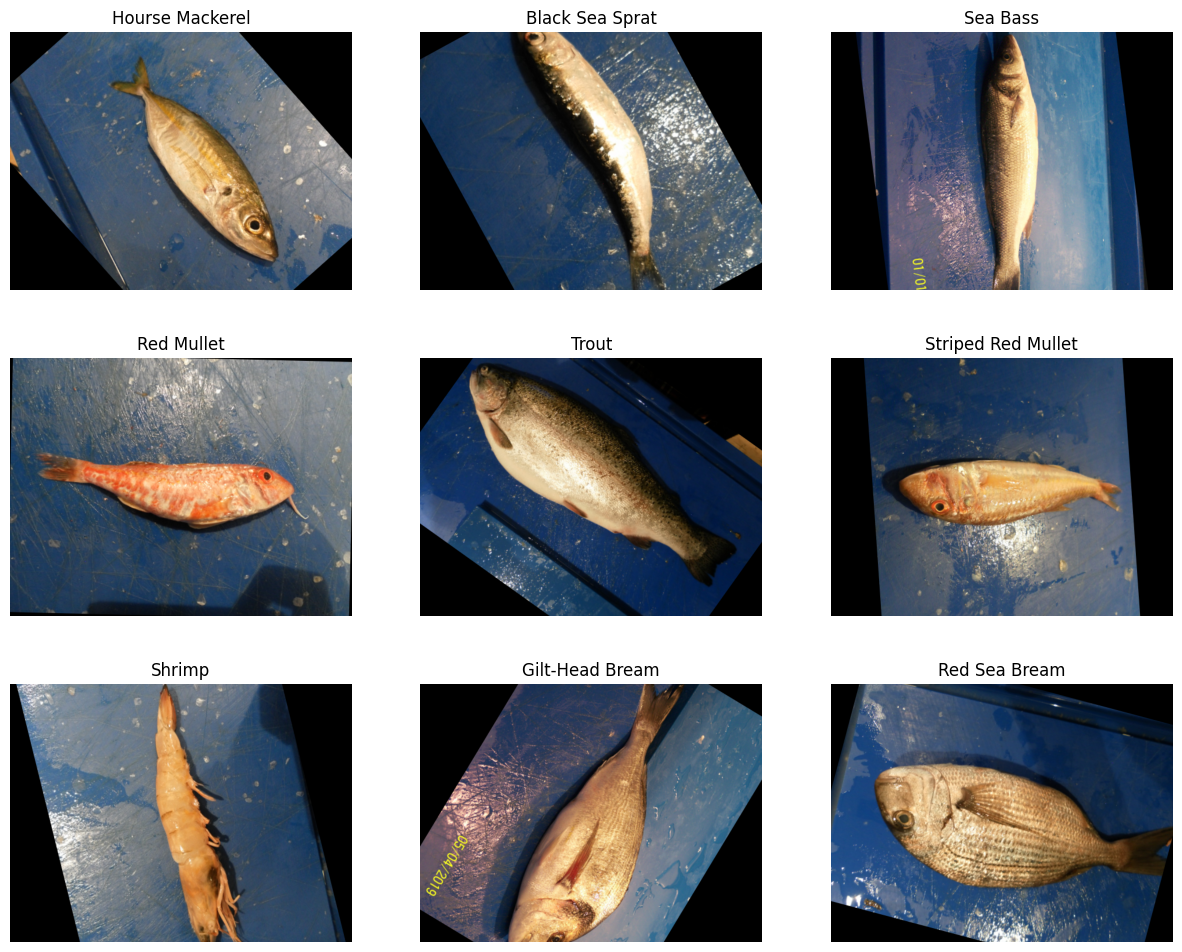

In [4]:
idx = 0
plt.figure(figsize=(15,12))
for unique_label in data['label'].unique():
    plt.subplot(3, 3, idx+1)
    plt.imshow(plt.imread(data[data['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    idx+=1

Verisetindeki Sınıfların dağılımı her balık türü için 1000 tane görsel var.

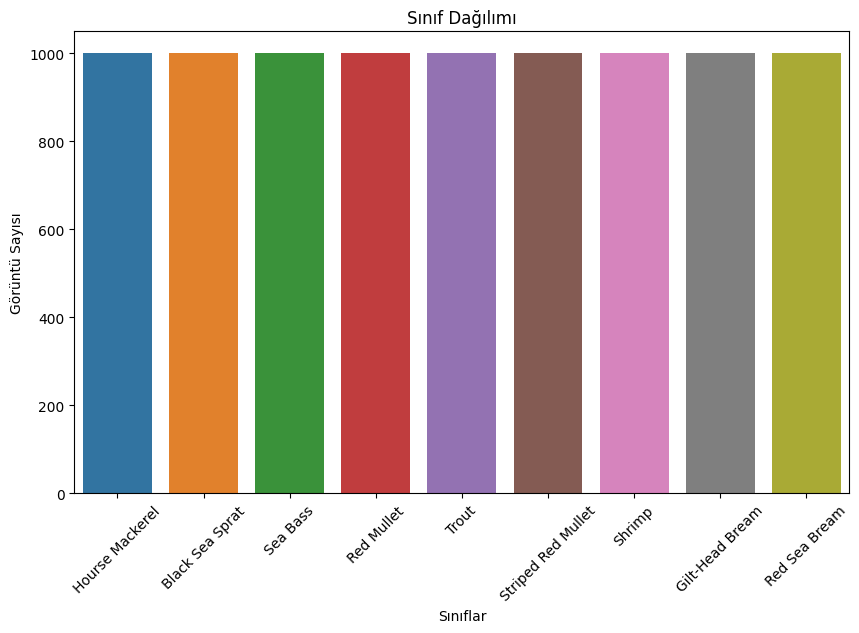

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=data)
plt.title('Sınıf Dağılımı')
plt.xlabel('Sınıflar')
plt.ylabel('Görüntü Sayısı')
plt.xticks(rotation=45)  
plt.show()


## **Veri Önişleme**

Veri setini eğitim ve test olarak bölmek için train_test_split fonksiyonunu kullandım. Test verisi için %20'lik bir oran belirledim.

In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

Verileri yeniden ölçeklendirmek ve doğrulama verisi oluşturmak için ImageDatagenerator kullandım. Eğitim verisinde veri artırımı denediğim de eğitim süreci olumsuz olarak etkilendiği için yorum satırına aldım.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode='nearest',
    validation_split=0.2,    
)

val_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2    
)

test_generator = ImageDataGenerator(rescale=1./255)

Eğitim, doğrulama ve test verilerin eğitim için hazır hale gelmesi. Eğitim süresini azaltmak için resim boyutlarını 28,28 olarak belirledim. Batch size'ı 64 olarak seçtim.

In [8]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=True, 
    seed=42, 
    subset='training'
)
val_images = val_generator.flow_from_dataframe(
    dataframe=train_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=True, 
    seed=42, 
    subset='validation' 
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=False 
)

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


## **Model**

Modeli oluştururken Flatten, Dense, BathcNormalization ve Dropout katmanlarını kullandım.

**Flatten:** Çok boyutlu girdiyi tek boyutlu bir vektöre dönüştürür.

**Dense:** Her nöronun, önceki katmandaki tüm nöronlara bağlandığı katmandır. Modelin öğrenmesini sağlar, sınıflandırma ve regresyon işlemlerinde kullanılır.

**BatchNormalization:** Aktivasyonları normalleştirir ve optimize eder. Eğitim sürecini hızlandırır ve kararlılık sağlar.

**Dropout:** Overfittingi önlemek için, eğitim sırasında bazı nöronları rastgele devre dışı bırakır.

**Modelin mimarisi**

Input layerda flatten katmanı ile veriyi vektöre dönüştürdüm. input_shape(28,28,3) olduğu için 2352 elamanlı vektöre dönüşüyor.

İlk hidden layerda 1024 nöronlu dense katmanı kullandım. Resim verisi ile çalıştığımız için ReLU aktivasyon fonksiyonunu kullandım. Modeli ilk oluşturduğumda overfitting yaptığı için l2 regularizasyonu ekledim katmana. **L2 regularizasyonu**, modelin kayıp fonksiyonuna ek bir terim ekleyerek büyük ağırlıkların cezalandırılmasını sağlar. 
Sonrasında BatchNormalization katmanıyla çıktıları normalleştirdim. Overfittingi önlemek için Dropout katmanı ekledim.

İkinci hidden layerda 512 nöronlu dense katmanı ekledim. Resim verisi ile çalıştığımız için ReLU aktivasyon fonksiyonunu kullandım. Modeli ilk oluşturduğumda overfitting yaptığı için l2 regularizasyonu ekledim katmana. Sonrasında BatchNormalization katmanıyla çıktıları normalleştirdim.

Üçüncü hidden layerda 256 nöronlu dense katmanı ekledim. Resim verisi ile çalıştığımız için ReLU aktivasyon fonksiyonunu kullandım. Modeli ilk oluşturduğumda overfitting yaptığı için l2 regularizasyonu ekledim katmana. İlk hidden layerdaki gibi dropout katmanı ekledim.

Dördüncü hidden layerda 128 nöronlu dense katmanı kullandım. Resim verisi ile çalıştığımız için ReLU aktivasyon fonksiyonunu kullandım. Modeli ilk oluşturduğumda overfitting yaptığı için l2 regularizasyonu ekledim katmana.

Beşinci hidden layerda 64 nöronlu dense katmanı kullandım. Resim verisi ile çalıştığımız için ReLU aktivasyon fonksiyonunu kullandım. Modeli ilk oluşturduğumda overfitting yaptığı için l2 regularizasyonu ekledim katmana. Ardından dropout katmanı kullandım.

Output layerda 9 nöronlu bir dense katmanı ekledim. 9 sınıflı bir problem çalıştığımız için nöron sayısının 9 olması gerekiyor. Aktivasyon fonksiyonu olarak 2'den fazla sınıf olduğu için softmax fonksiyonunu kullandım.




In [9]:
import tensorflow as tf
from tensorflow.keras import regularizers

model = tf.keras.models.Sequential()

# Model katmanlarını ekleyelim.

# Input Layer
model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 3))) 

# Hidden Layers
model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.2))


#Output Layer
model.add(tf.keras.layers.Dense(9, activation='softmax'))

Modeldeki parametre sayısı ve katmanları göstermek için summary fonksiyonunu kullandım.

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,409,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,113,481 (11.88 MB)

 Trainable params: 3,110,409 (11.87 MB)

 Non-trainable params: 3,072 (12.00 KB)

Overfittingi önlemek için early_stopping, ve LearningRateScheduler kullandım.

**EarlyStopping:** Modelin eğitimini, belirli bir ölçütün (genellikle doğrulama kaybı veya doğrulama başarımı) iyileşmemesi durumunda erken durdurur.

**LearningRateScheduler:**  Modelin öğrenme hızını (learning rate), eğitim süreci boyunca dinamik olarak ayarlar.

EarlyStopping ile 5 epochta validation loss değeri düşmez ise eğitim sürecini otamatik olarak durduruyor. 

lr_scheduler fonksiyonu ile 20. epochtan sonraki her epochta learning rate oranı %1 azalacak ve modelin daha stabil ve hassas bir şekilde öğrenmesini sağlayacak.

Optimizer olarak Adagrad kullandım. Adagradtan önce Adam, AdamW, SGD ve Adadelta optimizerları ile model eğitimleri yaptım en iyi sonucu Adagrad ile elde ettim.

loss fonksiyonu olarak categorical_crossentropy kullandım. 

Model başarımı ölçmek için accuracy, precision, recall ve F1Score metriklerini ekledim.

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

def lr_scheduler(epoch, lr):
    if epoch >= 20:
        lr *= 0.990 
    return lr

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

model.compile(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01), 
    loss='categorical_crossentropy',
    metrics=['accuracy','precision', 'recall', 'F1Score'],              
)



Eğitimi başlatmak için fit fonksiyonunu kullandım. Epoch sayısını 100 olarak belirledim. Ve yukarda tanımladığım callbackleri ekledim.

In [12]:
results = model.fit(
    train_images, 
    epochs=100, 
    batch_size=64, 
    validation_data=val_images,
    callbacks=[early_stopping,lr_scheduler_callback]
)


Epoch 1/100


I0000 00:00:1729264085.954565      72 service.cc:145] XLA service 0x79a44c007080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729264085.954624      72 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/90 ━━━━━━━━━━━━━━━━━━━━ 24:07 16s/step - F1Score: 0.0789 - accuracy: 0.0938 - loss: 5.0602 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1729264091.707450      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


90/90 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - F1Score: 0.2855 - accuracy: 0.2873 - loss: 4.6263 - precision: 0.5204 - recall: 0.0589 - val_F1Score: 0.3135 - val_accuracy: 0.3215 - val_loss: 4.5061 - val_precision: 0.8727 - val_recall: 0.0333 - learning_rate: 0.0100
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 67s 697ms/step - F1Score: 0.6157 - accuracy: 0.6213 - loss: 3.7887 - precision: 0.7901 - recall: 0.4146 - val_F1Score: 0.6195 - val_accuracy: 0.6313 - val_loss: 3.8214 - val_precision: 0.8778 - val_recall: 0.3042 - learning_rate: 0.0100
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 67s 701ms/step - F1Score: 0.7331 - accuracy: 0.7353 - loss: 3.4361 - precision: 0.8247 - recall: 0.6098 - val_F1Score: 0.7148 - val_accuracy: 0.7194 - val_loss: 3.4987 - val_precision: 0.8897 - val_recall: 0.5375 - learning_rate: 0.0100
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 67s 703ms/step - F1Score: 0.8136 - accuracy: 0.8157 - loss: 3.1597 - precision: 0.8806 - recall: 0.7458 - val_F1Score: 0.8673 - val_accuracy: 0.868

Eğitim sürecindeki eğitim ve doğrulama verisini loss ve accuracy grafikleri. 

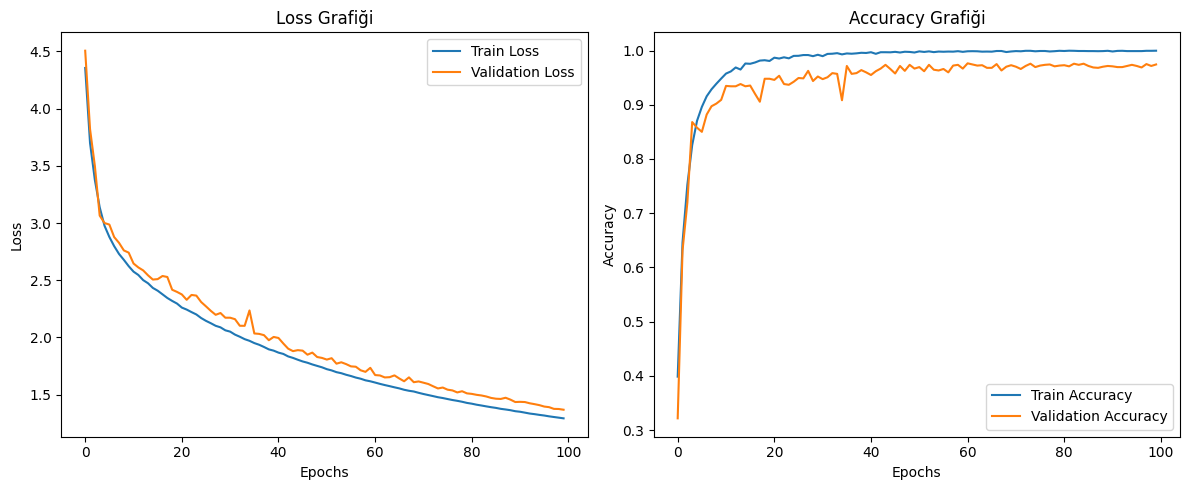

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Loss değeri için grafikleri çizdirelim.
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy score grafikleri çizdirelim.
plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Grafiklerde eğitim ve doğrulama verileri birbirine oldukça yakın hareket ediyor. Bu nedenle overfitting yaptığını söyleyemeyiz çünkü doğrulama başarımı da neredeyse eğitim başarımı kadar iyi performans gösteriyor.

## **Model Değerlendirmesi**

Model.predict ile test verilerinin tahminlerini yaptırdım. Daha sonra np.argmax ile tahminlediği sınıfları pred_classes değişkenine kaydettim.

In [14]:
import numpy as np

pred = model.predict(test_images)
pred_classes = np.argmax(pred, axis=1)


29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 995ms/step


test verisi için loss, accuracy, precision, recall ve f1_score değerlerini hesapladım.

In [15]:
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(test_images)

29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 580ms/step - F1Score: 0.9656 - accuracy: 0.9662 - loss: 1.3884 - precision: 0.9676 - recall: 0.9644


Test tahminleri ile Karmaşıklık matrisi oluşturma.

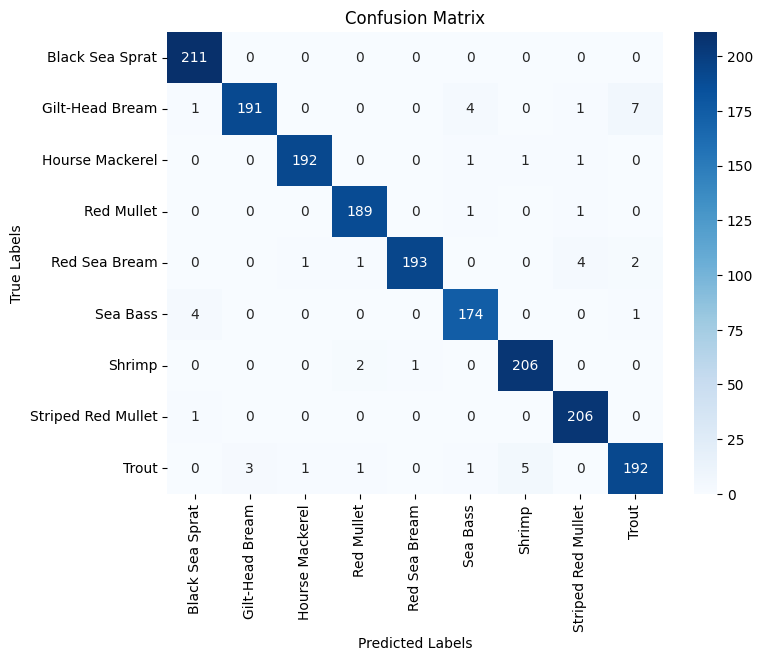

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_classes = test_images.classes
conf_matrix = confusion_matrix(true_classes, pred_classes)

# Sınıf etiketlerini alın
class_labels = list(test_images.class_indices.keys())

# Konfüzyon matrisini görselleştirin
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Test verisinin sınıflandırma raporu.

In [17]:
print(classification_report(true_classes, pred_classes, target_names=class_labels))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.97      1.00      0.99       211
   Gilt-Head Bream       0.98      0.94      0.96       204
   Hourse Mackerel       0.99      0.98      0.99       195
        Red Mullet       0.98      0.99      0.98       191
     Red Sea Bream       0.99      0.96      0.98       201
          Sea Bass       0.96      0.97      0.97       179
            Shrimp       0.97      0.99      0.98       209
Striped Red Mullet       0.97      1.00      0.98       207
             Trout       0.95      0.95      0.95       203

          accuracy                           0.97      1800
         macro avg       0.97      0.97      0.97      1800
      weighted avg       0.97      0.97      0.97      1800



Modelin test verisindeki verileri nasıl tahminlediğini gösteren bir figure oluşturdum.

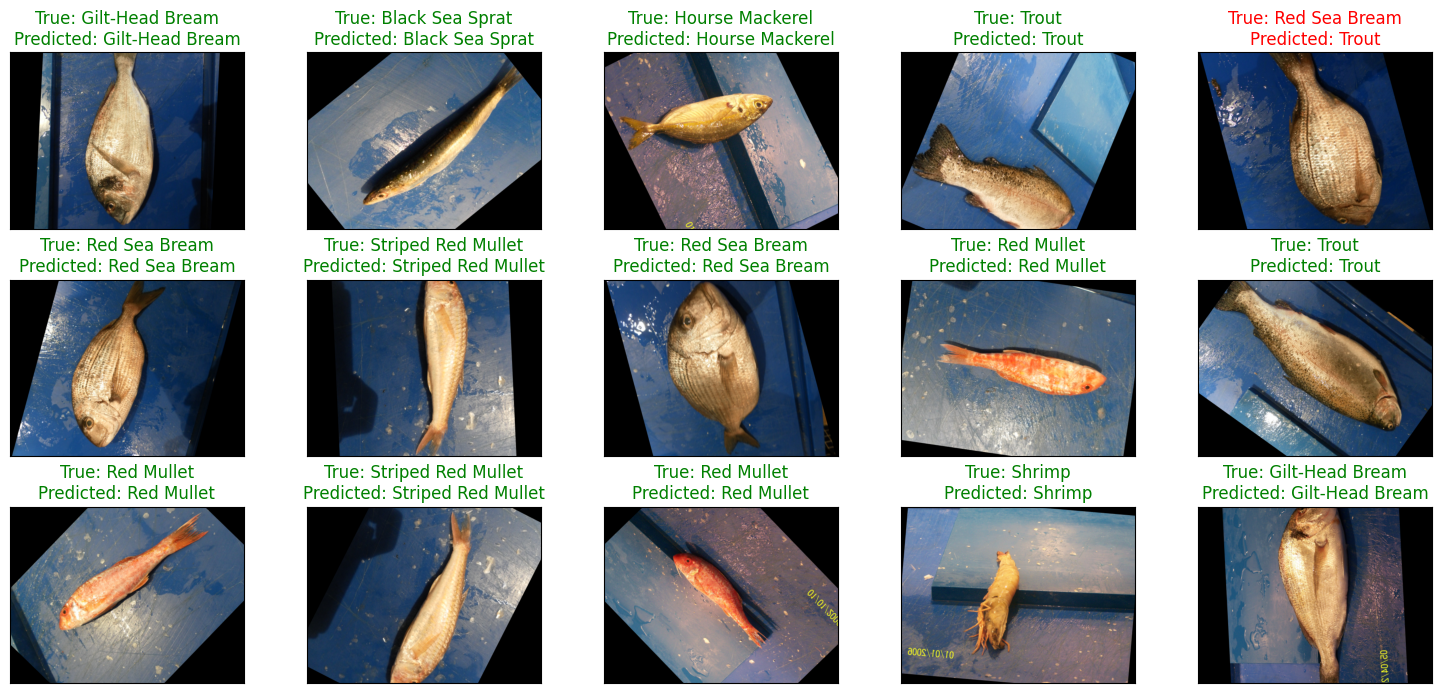

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_images.filepaths[i]))
    if test_images.labels[i] == pred_classes[i]:
        color = 'green'  
    else:
        color = 'red'    
    ax.set_title(f"True: {class_labels[test_images.labels[i]]}\nPredicted: {class_labels[pred_classes[i]]}", color = color)  

plt.tight_layout()
plt.show()
